# Apply both normal and special flats to spectra and save them in .fits files 

In [1]:
import os
import matplotlib.pyplot as plt
import re

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.io import fits
#from astropy.time import Time


## Input spectra 

In [17]:
spec_date = 20230117
spec_source = 'all'
spec_phys_filter = 'empty-holo4_003'

spec_path_base = './pseudo_postisrccd_img/'
spec_path_label = [d for d in os.listdir(spec_path_base) if str(spec_date) in d and spec_source in d and spec_phys_filter in d]
assert len(spec_path_label)==1
spec_path_label = spec_path_label[0]
spec_path = os.path.join(spec_path_base,spec_path_label)
spec_list = [f for f in os.listdir(spec_path) if 'exposure_' in f and spec_phys_filter in f]
for s_ in spec_list:
    print(s_)

exposure_2023011700239_empty-holo4_003_pseudo-postisrccd.fits
exposure_2023011700243_empty-holo4_003_pseudo-postisrccd_flat_special_flat.fits
exposure_2023011700248_empty-holo4_003_pseudo-postisrccd_flat_special_flat.fits
exposure_2023011700249_empty-holo4_003_pseudo-postisrccd_special_flat.fits
exposure_2023011700238_empty-holo4_003_pseudo-postisrccd_special_flat_special_flat.fits
exposure_2023011700249_empty-holo4_003_pseudo-postisrccd.fits
exposure_2023011700265_empty-holo4_003_pseudo-postisrccd.fits
exposure_2023011700238_empty-holo4_003_pseudo-postisrccd_flat.fits
exposure_2023011700275_empty-holo4_003_pseudo-postisrccd_flat_flat.fits
exposure_2023011700244_empty-holo4_003_pseudo-postisrccd_flat_flat.fits
exposure_2023011700243_empty-holo4_003_pseudo-postisrccd.fits
exposure_2023011700275_empty-holo4_003_pseudo-postisrccd_flat.fits
exposure_2023011700248_empty-holo4_003_pseudo-postisrccd.fits
exposure_2023011700266_empty-holo4_003_pseudo-postisrccd_special_flat.fits
exposure_20230

In [3]:
outdir = spec_path

Check that spectra are correctly read 

In [4]:
test_spec = fits.open(os.path.join(spec_path,spec_list[0]))
test_data = test_spec[1].data

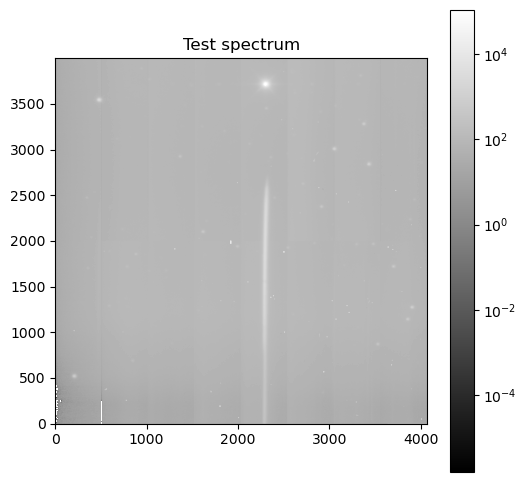

In [5]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
im = ax.imshow(test_data,cmap="gray",origin='lower',norm=LogNorm())
ax.set_title('Test spectrum')
plt.colorbar(im,ax=ax)

## Input flats 

First, we select a date 

In [6]:
flat_date = 20230116
flat_filter = 'empty_1'

flat_path_base = './special_flats/'
flat_path_ = os.path.join(flat_path_base,str(flat_date))

fpath_list = [f for f in os.listdir(flat_path_) if str(flat_date) in f]
for f_ in fpath_list:
    print(f_)

2023011600015


Then, we select a particular flat id 

In [7]:
flat_id = 2023011600015

flat_path = os.path.join(flat_path_,str(flat_id))

flat_list0 = [f for f in os.listdir(flat_path) if '.fits' in f and flat_filter in f]

flat_list = []
sflat_list = []
print('Available flats: ')
for f_ in flat_list0:
    flat_list = [f for f in flat_list0 if 'special' not in f]
    sflat_list = [f for f in flat_list0 if 'special' in f]
    print('        ',f_)
assert len(flat_list)==1
assert len(sflat_list)==1
flat_file = flat_list[0]
sflat_file = sflat_list[0]

Available flats: 
         special_flat_2023011600015_empty_1.fits
         flat_2023011600015_empty_1.fits


In [8]:
sflat = fits.open(os.path.join(flat_path,sflat_file))
flat = fits.open(os.path.join(flat_path,flat_file))

In [9]:
sflat_data = sflat[1].data
flat_data = flat[1].data
assert (sflat_data.shape==flat_data.shape)

Check that flats are correctly read 

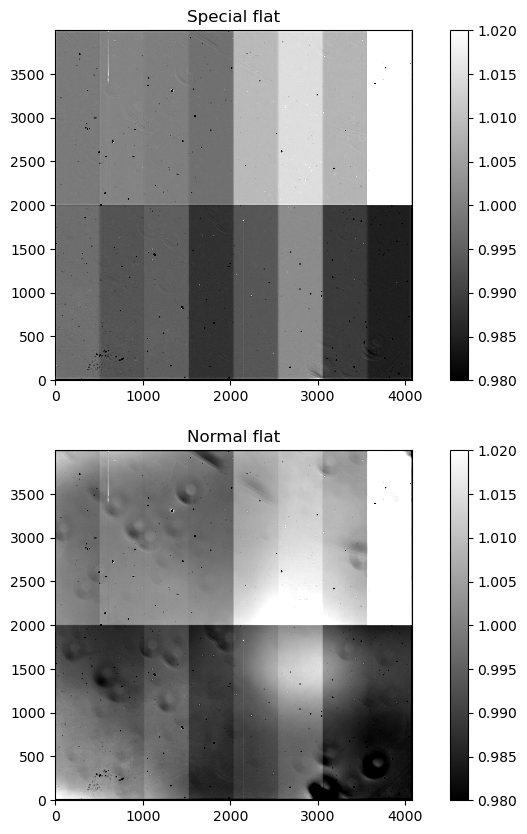

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
im = ax.imshow(sflat_data,cmap="gray",vmin=0.98,vmax=1.02,origin='lower')#,norm=LogNorm())
ax.set_title('Special flat')
plt.colorbar(im,ax=ax)
ax = fig.add_subplot(212)
im = ax.imshow(flat_data,cmap="gray",vmin=0.98,vmax=1.02,origin='lower')#,norm=LogNorm())
ax.set_title('Normal flat')
plt.colorbar(im,ax=ax)

## Important: 

Since the spectra were rotated as for Spectrator requirement, we need to rotate the flats in the same way in order to apply them to the spectra 

In [11]:
rot_sflat_data = sflat_data[::-1,::-1]
rot_flat_data = flat_data[::-1,::-1]
assert (rot_sflat_data.shape==rot_flat_data.shape)

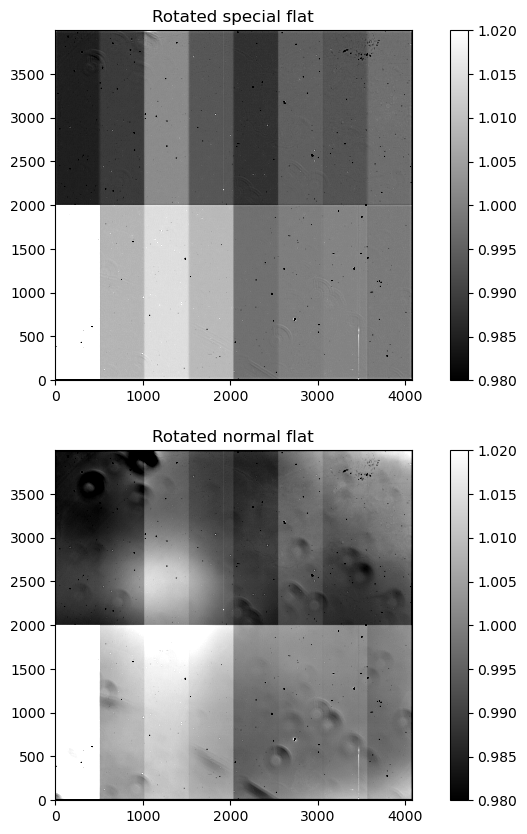

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
im = ax.imshow(rot_sflat_data,cmap="gray",vmin=0.98,vmax=1.02,origin='lower')#,norm=LogNorm())
ax.set_title('Rotated special flat')
plt.colorbar(im,ax=ax)
ax = fig.add_subplot(212)
im = ax.imshow(rot_flat_data,cmap="gray",vmin=0.98,vmax=1.02,origin='lower')#,norm=LogNorm())
ax.set_title('Rotated normal flat')
plt.colorbar(im,ax=ax)

We have a look at how a spectrum looks like when divided by a normal and a special flat: 

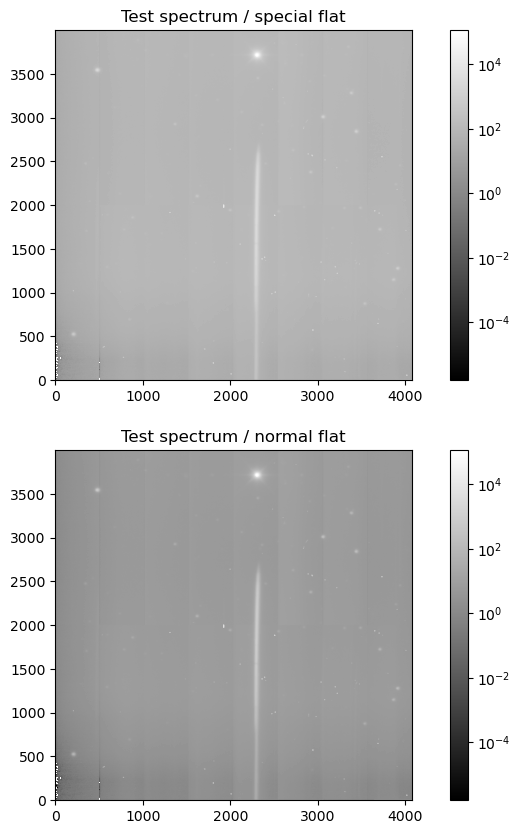

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
im = ax.imshow(test_data/rot_sflat_data,cmap="gray",origin='lower',norm=LogNorm())
ax.set_title('Test spectrum / special flat')
plt.colorbar(im,ax=ax)
ax = fig.add_subplot(212)
im = ax.imshow(test_data/rot_flat_data,cmap="gray",origin='lower',norm=LogNorm())
ax.set_title('Test spectrum / normal flat')
plt.colorbar(im,ax=ax)

We apply the normal and special flats to each spectra and save them separately 

In [14]:
for sname_ in spec_list:
    
    spec_ = fits.open(os.path.join(spec_path,sname_))
    spec_data_ = spec_[1].data
    
    filename_out_sflat = sname_.replace('.fits','_special_flat.fits')
    filename_out_flat = sname_.replace('.fits','_flat.fits')
    
    assert (spec_data_.shape==sflat_data.shape)
    
    spec_data_sflat = spec_data_/rot_sflat_data
    spec_data_flat = spec_data_/rot_flat_data
    
    hdr = spec_[0].header
    primary_hdu = fits.PrimaryHDU(header=hdr)
    image_hdu_sflat = fits.ImageHDU(spec_data_sflat)
    image_hdu_flat = fits.ImageHDU(spec_data_flat)
    
    hdu_list_sflat = fits.HDUList([primary_hdu, image_hdu_sflat])
    hdu_list_flat = fits.HDUList([primary_hdu, image_hdu_flat])
    
    hdu_list_sflat.writeto(os.path.join(outdir,filename_out_sflat),overwrite=True)
    hdu_list_flat.writeto(os.path.join(outdir,filename_out_flat),overwrite=True)
    
    